# Identifying Depression markers via social media,Facial expressions and building an early-stage recommendation engine

### Sayantika Banik-12020067
### Vaibhav Shah-12020080
### Sahithi Koppula-12010034

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv
/kaggle/input/sample-image/5b9b44d02200005700d8d086.jpeg


In [2]:
# Installation of necessary Libraries
!pip install torch===1.7.1+torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.4.12
!pip install --upgrade torch torchvision


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch===1.7.1+torchaudio===0.7.2 (from versions: 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.2.0+cpu, 1.2.0+cu92, 1.3.0, 1.3.0+cpu, 1.3.0+cu100, 1.3.0+cu92, 1.3.1, 1.3.1+cpu, 1.3.1+cu100, 1.3.1+cu92, 1.4.0, 1.4.0+cpu, 1.4.0+cu100, 1.4.0+cu92, 1.5.0, 1.5.0+cpu, 1.5.0+cu101, 1.5.0+cu92, 1.5.1, 1.5.1+cpu, 1.5.1+cu101, 1.5.1+cu92, 1.6.0, 1.6.0+cpu, 1.6.0+cu101, 1.6.0+cu92, 1.7.0, 1.7.0+cpu, 1.7.0+cu101, 1.7.0+cu110, 1.7.0+cu92, 1.7.1, 1.7.1+cpu, 1.7.1+cu101, 1.7.1+cu110, 1.7.1+cu92, 1.7.1+rocm3.7, 1.7.1+rocm3.8, 1.8.0, 1.8.0+cpu, 1.8.0+cu101, 1.8.0+cu111, 1.8.0+rocm3.10, 1.8.0+rocm4.0.1, 1.8.1, 1.8.1+cpu, 1.8.1+cu101, 1.8.1+cu102, 1.8.1+cu111, 1.8.1+rocm3.10, 1.8.1+rocm4.0.1, 1.9.0, 1.9.0+cpu, 1.9.0+cu102, 1.9.0+cu111, 1.9.0+rocm4.0.1, 1.9.0+rocm4.1, 1.9.0+rocm4.2, 1.9.1, 1.9.1+cpu, 1.9.1+cu102, 1.9.1+cu111, 1.9.1+rocm4.0.1, 1.9.1+rocm4.1, 1

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [4]:
# loading the dataset
df = pd.read_csv('../input/fer2013/fer2013.csv') 

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
print('Total lenth of dataset: ', len(df.Usage), '\n') # length of total dataframe
print('Total Categories we have: ', df.Usage.unique())
print('data in each category: ', '{ Training: ', len(df[df.Usage == 'Training']), ' PublicTest: ', len(df[df.Usage == 'PublicTest']), ' PrivateTest: ', len(df[df.Usage == 'PrivateTest']), '}\n')
print('Total Expression Classes: ', df.emotion.unique(), '\n')
print('pixel data type: ', type(df.pixels[0]))

Total lenth of dataset:  35887 

Total Categories we have:  ['Training' 'PublicTest' 'PrivateTest']
data in each category:  { Training:  28709  PublicTest:  3589  PrivateTest:  3589 }

Total Expression Classes:  [0 2 4 6 3 5 1] 

pixel data type:  <class 'str'>


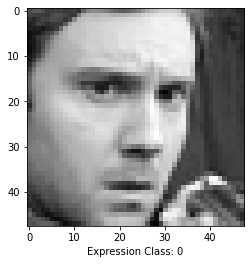

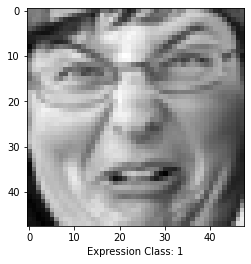

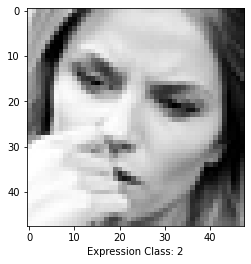

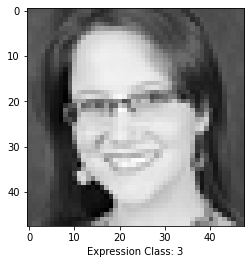

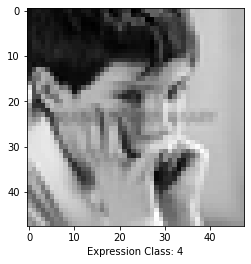

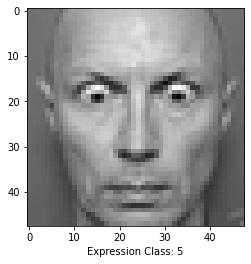

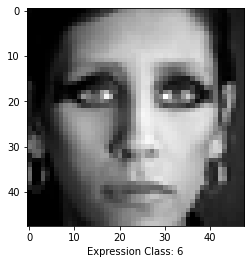

In [6]:
# Turning the pixels to a matrix of 48x48
def makemtrx(lst, n=48):
    for i in range(0, 48*48, n):  
        yield lst[i:i + n] 

# Function to show the images
def show(data):
    pixel = [int(i) for i in data[1].split(' ')]
    pixel = np.array(list(makemtrx(pixel)))
    plt.imshow(pixel, cmap='gray')
    plt.xlabel(f'Expression Class: {data[0]}')
    plt.plot()

for i in range(7):
    plt.figure()
    show(df[df.emotion == i].values[0])

In [7]:
#As the dataset has labels as numbers,Assigning those numbers the emotion category
classes = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

In [8]:
# Dataset prep for modeling
df_train = pd.concat([df[(df.Usage == 'Training')], df[df.Usage == 'PublicTest']], ignore_index=True).drop(['Usage'], axis=1)
df_test = df[df.Usage == 'PrivateTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)

# differentiating between labels and images
train_images = df_train.iloc[:, 1]
train_labels = df_train.iloc[:, 0]
test_images = df_test.iloc[:, 1]
test_labels = df_test.iloc[:, 0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# this is for the transformation of images to input into the model
train_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
    ])
val_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

In [10]:
# Creating class for our dataset 
class FERDataset(Dataset):
    
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = [int(m) for m in self.X[i].split(' ')]
        data = np.asarray(data).astype(np.uint8).reshape(48,48,1)
        data = self.transforms(data)
        label = self.y[i]
        return (data, label)
    
# transformed data assignment
train_data = FERDataset(train_images, train_labels, train_trfm)
val_data = FERDataset(test_images, test_labels, val_trfm)

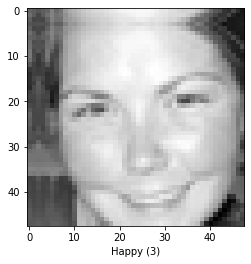

In [11]:
def show(data):
    img, lbl = data
    plt.figure()
    plt.imshow(torch.squeeze(img), cmap='gray')
    plt.xlabel(f'{classes[lbl]} ({lbl})')
    plt.plot()
    
show(train_data[8])

In [12]:
random_seed = 42
torch.manual_seed(random_seed);

In [13]:
batch_num = 400

train_dl = DataLoader(train_data, batch_num, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_num*2, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


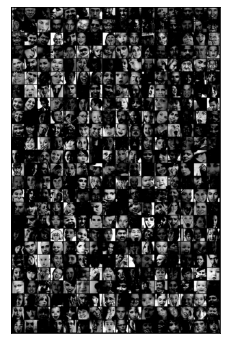

In [14]:
#Images of the data we are showing
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class FERBase(nn.Module):
    
    # batch from training dl
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # generates predictions by calling the training model
        loss = F.cross_entropy(out, labels)    # calculates loss 
        return loss
    
    #  batch from validation dl
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)            #  accuracy function to measure the accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # mean loss of the epoch batch
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()       # mean acc of the epoch batch
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

In [16]:
def conv_block(in_chnl, out_chnl, pool=False, padding=1):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FERModel(FERBase):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls))    # num_cls
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
        
        return self.classifier(out)
        
model = FERModel(1, 7)

In [17]:
for images, lbl in train_dl:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    break

shape of image:  torch.Size([400, 1, 48, 48])
shape of output:  torch.Size([400, 7])
Output:  tensor([-1.9475, -0.6722,  2.2308,  0.7485,  1.2213,  0.3419, -0.0255],
       grad_fn=<SelectBackward0>)


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [21]:
@torch.no_grad()    # this is for stopping the model from keeping track ofold parameters
def evaluate(model, val_loader):
    # This function will evaluate the model and give back the val acc and loss
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# getting the current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# this fit function follows the intuition of 1cycle lr
def fit(epochs, max_lr, model, train_loader=train_dl, val_loader=val_dl, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []    #keep track of the evaluation results
    
    # setting upcustom optimizer including weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up 1cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # record the lr
            lrs.append(get_lr(optimizer))
            sched.step()
            
        #validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(FERModel(1, 7), device)

In [23]:
evaluate(model, val_dl)

{'val_loss': 1.9597982168197632, 'val_acc': 0.043947942554950714}

In [24]:
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [25]:
history = fit(32, max_lr, model, weight_decay=weight_decay, grad_clip=grad_clip)


Epoch [0], last_lr: 0.00006, train_loss: 1.7253, val_loss: 1.5308, val_acc: 0.4167
Epoch [1], last_lr: 0.00014, train_loss: 1.4541, val_loss: 1.3900, val_acc: 0.4712
Epoch [2], last_lr: 0.00025, train_loss: 1.3322, val_loss: 1.3691, val_acc: 0.4909
Epoch [3], last_lr: 0.00039, train_loss: 1.2532, val_loss: 1.2299, val_acc: 0.5357
Epoch [4], last_lr: 0.00055, train_loss: 1.1873, val_loss: 1.1759, val_acc: 0.5584
Epoch [5], last_lr: 0.00070, train_loss: 1.1371, val_loss: 1.2252, val_acc: 0.5419
Epoch [6], last_lr: 0.00084, train_loss: 1.1035, val_loss: 1.1270, val_acc: 0.5826
Epoch [7], last_lr: 0.00094, train_loss: 1.0573, val_loss: 1.2116, val_acc: 0.5589
Epoch [8], last_lr: 0.00099, train_loss: 1.0296, val_loss: 1.0415, val_acc: 0.6078
Epoch [9], last_lr: 0.00100, train_loss: 0.9998, val_loss: 1.1828, val_acc: 0.5655
Epoch [10], last_lr: 0.00099, train_loss: 0.9678, val_loss: 1.0442, val_acc: 0.6153
Epoch [11], last_lr: 0.00097, train_loss: 0.9358, val_loss: 1.1995, val_acc: 0.5540
Ep

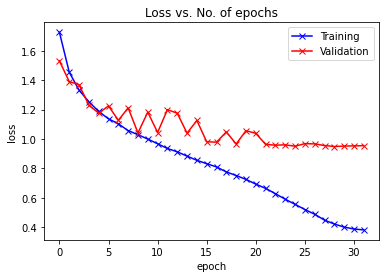

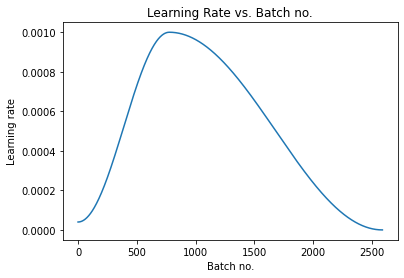

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_losses(history)
plt.figure()
plot_lrs(history)

In [27]:
##To further experiment with real time detection of emotions , created this model to run the python script on our local
torch.save(model.state_dict(), 'emotion_detection.pth')


## Testing our Model on a sample  Fear image downloaded from the internet

In [37]:
#function to turn photos to tensor
def img2tensor(x):
    transform = transforms.Compose(
            [transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))])
    return transform(x)

# the model for predicting
model = FERModel(1, 7)
softmax = torch.nn.Softmax(dim=1)
model.load_state_dict(torch.load('emotion_detection.pth', map_location=get_default_device()))

def predict(x):
    out = model(img2tensor(img)[None])
    scaled = softmax(out)
    prob = torch.max(scaled).item()
    label = classes[torch.argmax(scaled).item()]
    return {'label': label, 'probability': prob}


In [29]:
import cv2
# Load an color image in grayscale
img = cv2.imread('../input/sample-image/5b9b44d02200005700d8d086.jpeg',0)
resized = cv2.resize(img, (48, 48))   

In [31]:
# predict the mood
img = img2tensor(resized)
prediction = predict(img)

In [32]:
prediction

{'label': 'Fear', 'probability': 0.36630359292030334}

In [67]:
##The model has correctly predicted the image to be fear

In [45]:
prediction['probability']

0.36630359292030334

## Facial expresions coupled with data from social media to predict the depression markers
## We have used twitter data for the current project

In [34]:
! pip install text2emotion

     |████████████████████████████████| 57 kB 816 kB/s            


In [61]:
import text2emotion as te
#text_tweet = input()
text_tweet='I enjoy controlled loneliness. I like wandering around the city alone. I’m not afraid of coming back to an empty flat and lying down in an empty bed. I’m afraid of having no one to miss, of having no one to love'
res = te.get_emotion(text_tweet)

print(res)

{'Happy': 0.22, 'Angry': 0.0, 'Surprise': 0.11, 'Sad': 0.44, 'Fear': 0.22}


In [39]:
type(res)

dict

# Recommendation system


## From the facial expressions we are able to identify Fear as a significant emotion and from the tweets of that person we have identified her to be lonely /sad currently and generic recommendtaions to treat and overcome the emotional baggage early

In [66]:

if len(predict(img)) !=0 or len(res)!=0:
    if res['Fear'] or res['Sad'] or res['Angry'] and Labels[label]=='Fear' or Labels[label]=='Angry' or Labels[label]=='Sad' or Labels[label]=='Disgust':
        final_vector = res['Fear'] +res['Sad']+res['Angry']+ prediction['probability']
        if final_vector >0.8:
            if prediction['label']=='Fear':
                print('Hi,Fear keeps us focused on the past or worried about the future. If we can acknowledge our fear, we can realize that right now we are okay. Right now, today, we are still alive, and our bodies are working marvelously. Our eyes can still see the beautiful sky. Our ears can still hear the voices of our loved ones.')
                print('--------------')
                print('Our Tailormade Recommendations to make the best of your day')
                print('--------------')
                print('Practice Mindulness' + ' ' "https://www.mindful.org/mindfulness-how-to-do-it/")
                print('30 to 60 minutes of aerobic activity '+ ' ' "https://30dayfitness.app/")
                print('Ensure proper sleep of 8 hours for atleast a week'+ ' '"https://www.sleepfoundation.org/sleep-diary")
                print('Attend a meetup in your city' + "  ""https://www.meetup.com/cities/in/hyderabad/outdoors-adventure/")
                print('checkout this happiness project blog' + '' "https://gretchenrubin.com/2012/02/every-wednesday-is-tip-day-this-wednesday-four-tips-for-writing-your-personal-commandments-im-doing-a-happiness-pro/")
            if prediction['label']=='Angry':
                print('“Holding on to anger is like grasping a hot coal with the intent of throwing it at someone else; you are the one who gets burned.”)
                print('--------------')
                print('Our Tailormade Recommendations to make the best of your day')
                print('--------------')
                print('start a gratitude journal' + "https://greatergood.berkeley.edu/article/item/tips_for_keeping_a_gratitude_journal")
                print('Identify your anger triggers' +' '+"https://www.verywellmind.com/anger-management-strategies-4178870")
                print('30 to 60 minutes of aerobic activity '+ ' ' "https://30dayfitness.app/")
                print('Hangout with a friend '  +'https://www.stumagz.com/in/10-corners-to-hang-out-to-have-an-amusing-day-in-hyderabad-/')
            
        
        
        
        

Hi,Fear keeps us focused on the past or worried about the future. If we can acknowledge our fear, we can realize that right now we are okay. Right now, today, we are still alive, and our bodies are working marvelously. Our eyes can still see the beautiful sky. Our ears can still hear the voices of our loved ones.
--------------
Our Tailormade Recommendations to make the best of your day
--------------
Practice Mindulness https://www.mindful.org/mindfulness-how-to-do-it/
30 to 60 minutes of aerobic activity  https://30dayfitness.app/
Ensure proper sleep of 8 hours for atleast a week https://www.sleepfoundation.org/sleep-diary
Attend a meetup in your city  https://www.meetup.com/cities/in/hyderabad/outdoors-adventure/
checkout this happiness project bloghttps://gretchenrubin.com/2012/02/every-wednesday-is-tip-day-this-wednesday-four-tips-for-writing-your-personal-commandments-im-doing-a-happiness-pro/
